#Dissipative Driven Entanglement Notebook
Author: Eugene Dumitrescu

In this notebook we (loosely) follow the prescription of Refs[1,2] to simulate the dynamical entanglement of QD systems coupled to a quantum environment. The approach taken is based on cavity QED, however our aim is to replace the cavity with a plasmonic reservoir.

### References
* [M. Otten, R. A. Shah, N. F. Scherer, M. Min, M. Pelton, and S. K. Gray, Phys. Rev. B 92, 125432 (2015)](http://journals.aps.org/prb/abstract/10.1103/PhysRevB.92.125432)
* [Dissipation-driven entanglement between qubits mediated by plasmonic nanoantennas](http://journals.aps.org/prb/abstract/10.1103/PhysRevB.89.235413)


In [85]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from qutip import *
import scipy.signal as ss

# operators acting on the composite spin-boson Hilbert space
def I(N,M):
    """Identity"""
    oplist = [qeye(2)] * N
    oplist.append(qeye(M))
    return tensor(oplist)

# spin operators
def sx(i, N, M):
    """Pauli X on qb i"""
    oplist = [qeye(2)] * N
    oplist[i] = sigmax()
    oplist.append(qeye(M))
    return tensor(oplist)

def sy(i, N, M):
    """Pauli Y on qb i"""
    oplist = [qeye(2)] * N
    oplist[i] = sigmay()
    oplist.append(qeye(M))
    return tensor(oplist)

def sz(i, N, M):
    """Pauli Z on qb i"""
    oplist = [qeye(2)] * N
    oplist[i] = sigmaz()
    oplist.append(qeye(M))
    return tensor(oplist)

def sm(i, N, M):
    """destroy quanta on qb i"""
    oplist = [qeye(2)] * N
    oplist[i] = sigmam()
    oplist.append(qeye(M))
    return tensor(oplist)

def sp(i, N, M):
    """create quanta on qb i"""
    oplist = [qeye(2)] * N
    oplist[i] = sigmap()
    oplist.append(qeye(M))
    return tensor(oplist)

def d(i,N,M):
    """dipole operator for ith spin"""
    return sp(i, N, M) + sm(i, N, M)

# plasmon / EM mode operators
def a(N, M):
    """bosonic annihiliation operator"""
    oplist = [qeye(2)] * N
    oplist.append(destroy(M))
    return tensor(oplist)

def n_a(N,M):
    """bosonic number operator"""
    return a(N,M).dag() * a(N,M)

def d_a(N,M):
    """bosonic dipole operator"""
    return a(N,M).dag() + a(N,M)

# spin subspace projection operators 
def P_S(N,M):
    """Symmetric |s = 1, m_l = 0> subspace projector"""
    return .25 * (I(N,M) - sz(0,N,M) * sz(1,N,M) + sx(0,N,M) * sx(1,N,M) + sy(0,N,M) * sy(1,N,M))

def P_A(N,M):
    """Anti-symmetric |s = 0, m_l = 0> subspace projector"""
    return .25 * (I(N,M) - sz(0,N,M) * sz(1,N,M) - sx(0,N,M) * sx(1,N,M) - sy(0,N,M) * sy(1,N,M))

def P_pp(N,M):
    """|++> subspace projector """
    return np.prod([sp(i,N,M) * sm(i,N,M)  for i in range(N)])

def P_mm(N,M):
    """|--> subspace projector """
    return np.prod([sm(i,N,M) * sp(i,N,M)  for i in range(N)])


## Hamiltonian and Model

Our model Hamiltonian for a N two levels systems (TLS) interacting with a bosonic reservoir is 
<center> $H = H_0 + H_{int} + H_{drv}$ </center>
where the individual, interacting, and driving components of the Hamiltonian are given by 
<center>
$\displaystyle H_0 = - \omega_0 \sum_{i=1}^N \sigma_z^{(i)} + \omega_c a^\dagger a$
</center>
<center>
$\displaystyle H_{int} = - \sum_{i}^N g_i (\sigma^{+}a + \sigma^{-}a^\dagger)$
</center>
<center>
$\displaystyle H_{drv} = - \sum_{i}^N \Omega_i \hat{d}_i + \Omega_a \hat{d}_a$
</center>
We have used the EM field and TLS dipole operators $\hat{d}_i = \sigma^+_{(i)}+\sigma^-_{(i)}$ and $\hat{d}_a = a + a^\dagger$  in the driving term and we have also applied the rotating wave approximation.

In [121]:
def Ham(ws,gs,ds):
    """ Define the Hamiltonian as a sum over:

    Terms
    -----
    H_0: non-interacting systems
    H_RWA: interaction between subsystems in the rotating wave approximation
    H_DRV: driving terms in the co-rotating reference frame
    
    Returns
    -------
    
    Hermitial Hamiltonian operator
    H_0 - H_RWA - H_DRV
    """
    H_0   = sum(ws[i] * sp(i,N,M) * sm(i,N,M) for i in range(N)) + ws[N] * n_a(N,M)
    H_RWA = sum(gs[i] * (a(N,M) * sp(i,N,M) + a(N,M).dag() * sm(i,N,M)) for i in range(N))
    H_DRV = sum(ds[i] * d(i,N,M) for i in range(N)) + ds[N] * d_a(N,M)
    return H_0 - H_RWA - H_DRV


def cops(kappa, gamma, deph, n_th):
    """
    Define collapse operators for Lindblad master equation
    
    Parameters
    ----------
    kappa: cavity relaxation rate,  ~ 500 THz ~ 2 eV
    gamma: emitter relaxation rate, ~ 10 MHz ~ 1mueV
    gdph: emitter dephasing rate,   ~ same as relaxation rate
    n_th: temperature for entire system, gives excitation rate

    Returns
    -------
    c_ops: list of collapse operators
    """
    c_ops = []
    for i in range(2):
        rate = np.sqrt(gamma * (1 + n_th))
        if rate > 0.0:
            c_ops.append(rate * sm(i,N,M))        # relaxation
        rate = gamma * n_th
        if rate > 0.0:
            c_ops.append(rate * sm(i,N,M).dag())  # excitation
        c_ops.append(np.sqrt(deph) * sz(i,N,M))   # dephasing  
    rate = np.sqrt(kappa * (n_th + 1))
    if rate > 0: 
        c_ops.append(rate * a(N,M))
    rate = np.sqrt(kappa * (n_th))
    if rate > 0: 
        c_ops.append(rate * a(N,M).dag())
    return c_ops

def g2(sta, ham, lin, tim):
    """
    Parameters
    ----------
    sta: initial state to evolve according to 
    ham: Hamiltonian matrix and 
    lin: Lindbladian operators for 
    tim: times 
    
    Returns
    -------
    g^(2)(tau) second order correlation function
    """
    e_ss_ops = [sp(i,N,M) * sm(i,N,M) for i in range(N)]        # qubit occupation number operators
    rho_ae = [sm(i,N,M) * sta * sp(i,N,M) for i in range(N)]    # track all possible emission events
    
    # solve for <sp*sm> with respect to the post emission state
    results = [mesolve(ham, r, tim, lin, e_ss_ops) for r in rho_ae]
    
    # steady state g2 denominator/normalization constants
    denoms = [np.real((e * sta).tr()) for e in e_ss_ops]  
    return sum(results[i].expect[j] / (denoms[i] * denoms[j]) / float(N**2) for i in range(N) for j in range(N))


def freq(pwrspec, o = 1):
    """
    Extract the primary non-decay frequency from the 
    Parameters
    ----------
    pwrspec: g2 power spectrum
    order: number of points frequencym must be above to count as local maxima    
    Returns
    -------
    two qubit 'Rabi' frequency -- lowest one which emerges.... should probably be the biggest?
    """
    print(o)
    fs = ss.argrelmax(pwrspec[0:int(len(pwrspec)/2)], order = o) # candidate characteristic frequencies
    M = [pwrspec[f] for f in fs][0]                       # power spectrum magnitude of frequencies 
    return fs[0][np.ndarray.argmax(M)]

# Dynamical Evolution

Let us initialize system with one dot excited and the other in the ground state and allow the system to evolve dissipatively. Short lived entanglement, as measured by the concurrence, should be generated between the dots; although asymmetric couplings may be needed to realize the expected result. 


## Master Eqaution:

# Correlations

We proposed to optically characterize the entanglement generated in our device by means of the normalized second order coherence function:

<center>
$\displaystyle g^2(r_1,t_1;r_2,t_2) = \frac{\langle a^\dagger (r_1,t_1) a^\dagger (r_2,t_2) a(r_2,t_2) a(r_1,t_1) \rangle}{\langle a^\dagger(r_1,t_1) a(r_1,t_1) \rangle \langle a^\dagger(r_2,t_2) a(r_2,t_2) \rangle}$
</center>

Suppose we probe light from the same spatio-temporal source (i.e. a stationary process with $r_1=r_2$) and introduce a time delay denoted by $\tau = t_2 - t_1$. In this case $g^2$ does not depend on $t_1$ and $t_1$ but only on their difference $\tau$. We can then express the second order coherence function in the following form:

<center>
$\displaystyle g^2(t, \tau) = \frac{\langle a^\dagger (t) a^\dagger (t + \tau) a(t + \tau) a(t) \rangle}{\langle a^\dagger(t) a(t) \rangle^2}$
</center>

Below we show 2 coherence functions. In the first $t$ is set to $0$ such that $g^2(0,\tau)\equiv g^2(\tau)$ and correlations are therefore calculated with respect to the initial (Fock state) of the cavity. One may also calculate the correlation function in the limit $t \rightarrow \infty$ such that the correlations are calculated with respect to the steady state solution (provided such a solution exists).


# Numerical Solution

In order to calculate the second order correlation function we follow the following procedure

- Take the steady state $\rho_{ss}$ and simulate an emission event by destroying a single quanta of energy 
    - Note this could technically occur in either of the emitters *or* in the plasmonic cavity. For now we assume the emitters are responsible for the spontaneous emission. 
- Evolve the system in time and renormalize by the steady state $g^2$ denominator
    


## compare $g^{(2)}(0)$ vs the concurrence

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


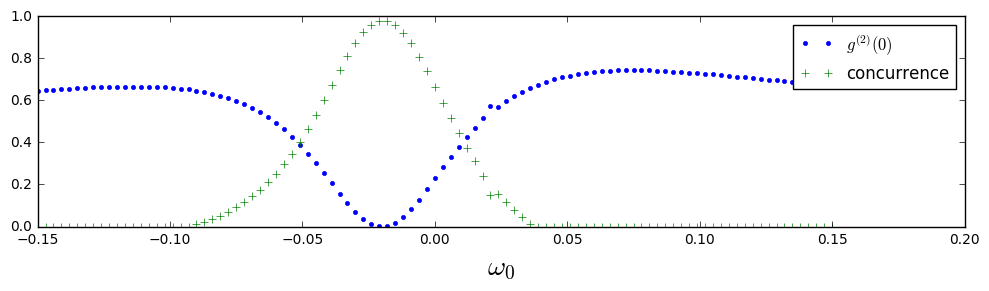

In [9]:
# expectation value for QD occupation number
e_ss_ops = [sp(0,N,M) * sm(0,N,M), sp(1,N,M) * sm(1,N,M)]

# discretized g2 time domain
taus = np.linspace(0,1.5e2, 2e3)

# parameter range
num = 101
w_range = np.linspace(-.15, 0.15, num)
wss = [[0.02, w, 0.0] for w in w_range]
g2zd = [0] * num
cnc = [0] * num

for i in range(num):
    # density matrices before emission (steady state) and after emission (ae)
    rho_ss = steadystate(Ham(wss[i], gs, ds), cops(kap, gam, gdph, n_th))
    cnc[i] = concurrence(ptrace(rho_ss,[0,1]))   # steady state concurrence
    
    rho_ae = [sm(0,N,M) * rho_ss * sp(0,N,M), sm(1,N,M) * rho_ss * sp(1,N,M)] 
    rho_ae = [r/r.tr() for r in rho_ae]
    g2zd[i] = sum((e_op * r).tr() for e_op in e_ss_ops for r in rho_ae)
    
fig, ax = plt.subplots(1, figsize=(10, 3))
ax.set_xlabel('$\omega_0$', fontsize=20)
# plt.colorbar(mpbl)
ax.plot(w_range, g2zd, '.', label = '$g^{(2)}(0)$')
ax.plot(w_range, cnc, '+', label = 'concurrence')
plt.tight_layout()
plt.legend()
# plt.savefig("g2_detuning_diagram.pdf")
plt.show()

# Finite Delay characteristic anti-bunching timescales

It is difficult to identify the full-width half maximum because the maximum may actually occur at relaxation timescales. That is, no local maxima from "beading" is seen before the onset of long time relaxation -- back to unity as required in the long time limit. This means that the driving frequency is masked by the relaxation frequency. However we can still try to extract this feature by Fourier forming the transient signal and extracting the effectiv Rabi driving frequency numerically.  

We study the anti-bunching lifetime as a function of:
1. Detuning
2. Coupling strength
3. Driving amplitude -- good lead. This seems to be effective



/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:19: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


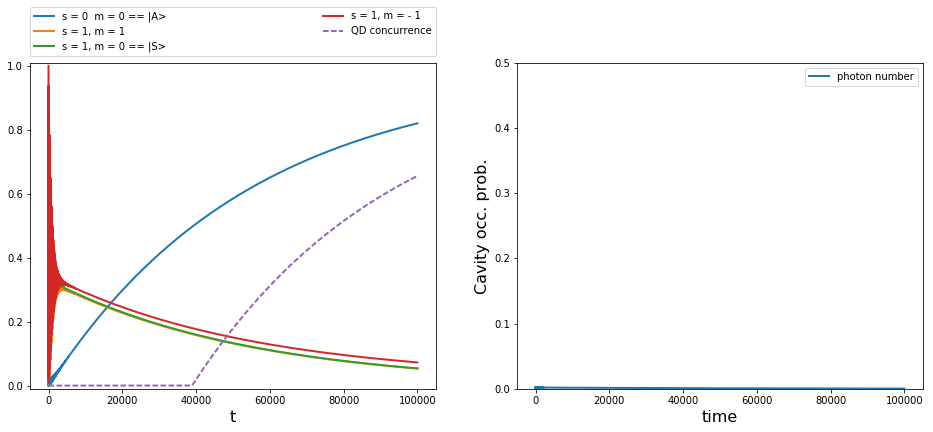

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:52: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


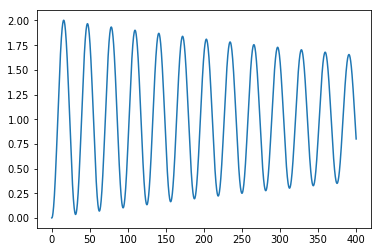

In [96]:
ws = [0.02, -0.02, 0.0]      # frequency/level spacing of each individual system
gs = [0.02, 0.02]              # position dependent couplings
ds = [0.1, 0.1, 0]           # driving strengths qb0,1, bosons 

kap = 1
gam = kap * 1e-8
gdph = 2 * kap * 1e-8
n_th = 0

Hammy = Ham(ws,gs,ds)
c_ops = cops(kap, gam, gdph, n_th)
# Initial state
psi_0 = basis(2,1)                   # qb 1  ground state
psi_1 = basis(2,1)                   # qb 2 excited state
psi_c = basis(M,0)                   # initial fock state
psi_tot = tensor(psi_0,psi_1,psi_c)  # tensor product

# discretized time domain
tlist = np.linspace(0,1e5, 1e4)

# run dynamics solver
result = mesolve(Hammy, psi_tot, tlist, c_ops, [])

# expectation value operators: subspace occupation number projectors and concurrence
e_ops = [P_S(N,M), P_A(N,M), P_pp(N,M), P_mm(N,M), n_a(N,M)]
Ex_P_S, Ex_P_A, Ex_Ppp, Ex_Pmm, Ex_n_a = [[expect(e,st) for st in result.states] for e in e_ops]
concr = [concurrence(ptrace(st,(0,1))) for st in result.states]

#plot results
fig, axes = plt.subplots(1, 2, figsize=(16,6))

times = tlist      # renormakize time units
axes[0].plot(times, Ex_P_A, '-', linewidth=2, label="s = 0  m = 0 == |A>")
axes[0].plot(times, Ex_Ppp, '-', linewidth=2, label="s = 1, m = 1")
axes[0].plot(times, Ex_P_S, '-', linewidth=2, label="s = 1, m = 0 == |S>")
axes[0].plot(times, Ex_Pmm, '-', linewidth=2, label="s = 1, m = - 1")
axes[0].plot(times, concr , '--', linewidth=2, label="QD concurrence")
axes[0].set_ylim(-.01,1.01)
axes[0].set_xlabel("t", fontsize=16)
axes[0].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)

axes[1].plot(times, Ex_n_a, '-', linewidth=2, label="photon number")
axes[1].set_ylim(0, .5)
axes[1].set_ylabel("Cavity occ. prob.", fontsize=16)
axes[1].set_xlabel("time", fontsize=16)
axes[1].legend(loc=0)
# np.transpose([Ex_P_A, Ex_Ppp, Ex_P_S, Ex_Pmm])  # plotted data
plt.show()


# discretized time domain
tlist = np.linspace(0,4e2, 2e3)
p_ss = steadystate(Hammy, c_ops)
g = g2(p_ss, Hammy, c_ops, tlist)
plt.plot(tlist, g)
plt.show()

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:5: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:75: RuntimeWarning: invalid value encountered in true_divide


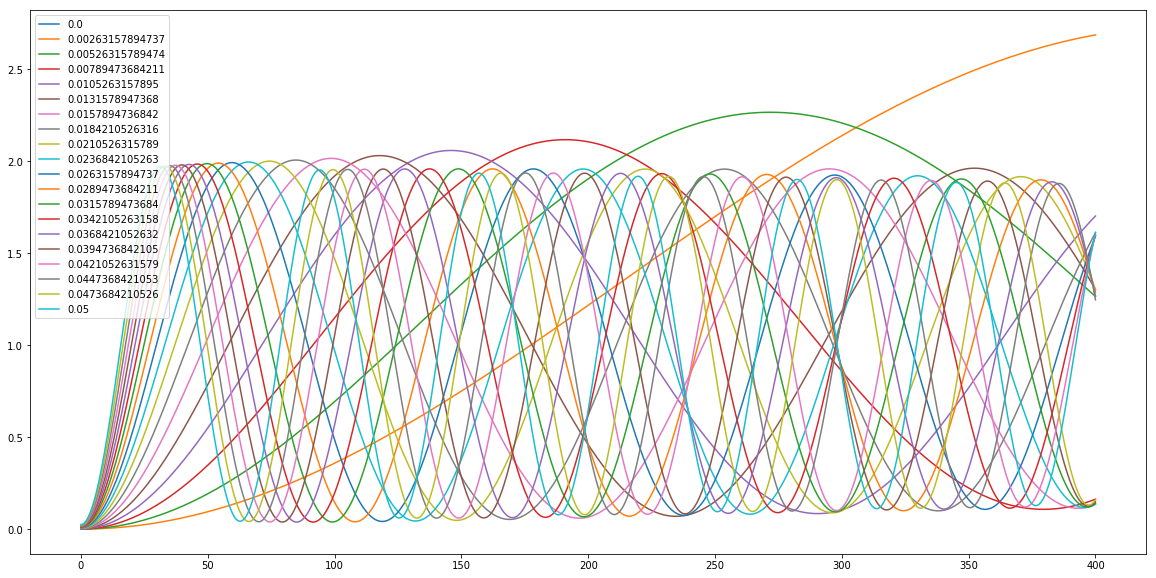

In [102]:
ws = [0.005, -0.005, 0.0]      # frequency/level spacing of each individual system
gs = [0.01, 0.01]            # position dependent couplings
ds = [0.1, 0.1, 0]           # driving strengths qb0,1, bosons 
drange=np.linspace(0,.05,20)
tlist = np.linspace(0,4e2, 2e3) # discretized time domain


plt.figure(figsize=(20,10))
for dr in drange:
    Hammy = Ham(ws,gs,[dr,dr,0])
    p_ss = steadystate(Hammy, c_ops)
    g = g2(p_ss, Hammy, c_ops, tlist)
    plt.plot(tlist, g, label = str(dr))
plt.legend()
plt.show()

### Frequency phase diagrams

The dissipative generation of a robust enagned steady state is well established but, as discussed previously, a simple robust verification thereof is lacking. 
It has previously been hypothesized that the second order correlation function could be used as 'the smoking gun' signature for this entanglement. 
The $g^{(2)}(\tau)$ details vary depending on the propasal. 

Standard DDE protocls generate the anti-symmetric bell state ($|T\rangle = |01\rangle + |10\rangle$). 
Such a state must act as a single quantum emitter with an anti-bunching signature as discussed in (Garcia-Vidal_2011).
While extremely promising, this feasability of detecting this effect far from established due to the fast timescales involved in plasmonic systems. 

Below, we explicitely consider this problem and show that the effective Rabi frequency driving the 

some experimental details of time scales are unknown.
Our goal is to ascertain what physical constants lead to an easily observed anti-bunching effect.

# Complete Analysis
of the following results:
1. Concurrence
2. Zero delay anti-bunching
3. Rabi frequency (and therefore timescales)
Goal is to put everything in the same place for clarity. 

The code panels below analyze:
1. Detunings
2. Coupligs
3. Drivings ()

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:26: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
0 100
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 39
1 40
1 41
1 42
1 43
1 44
1 45
1 46
1 47
1 48
1 49
1 50
1 51
1 52
1 53
1 54
1 55
1 56
1 57
1 58
1 59
1 60
1 61
1 62
1 63
1 64
1 65
1 66
1 67
1 68
1 69
1 70
1 71
1 72
1 73
1 74
1 75
1 76
1 77
1 78
1 79
1 80
1 81
1 82
1 83
1 84
1 85
1 86
1 87
1 88
1 89
1 90
1 91
1 92
1 93
1 94
1 95
1 96
1 97
1 98
1 99
1 100
2 0
2 1


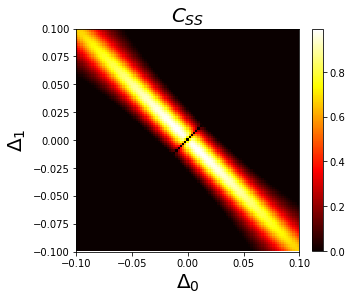

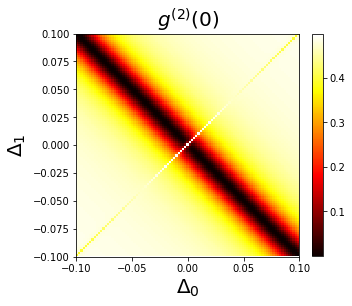

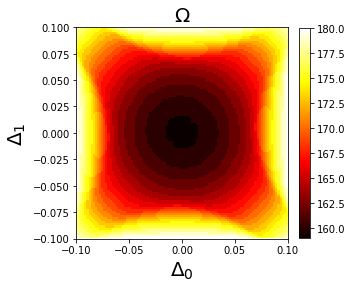

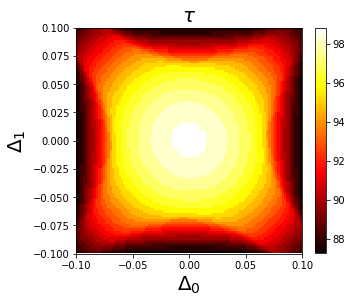

In [58]:
N = 2          # Number of spin 1/2's
M = 3          # Number of cavity modes

ws = [0.02, -0.02, 0.0]      # frequency/level spacing of each individual system
gs = [0.1, 0.1]              # position dependent couplings
ds = [0.1, 0.1, 0]           # driving strengths qb0,1, bosons 

# Lindblad collapse operators defined way above
cps = cops(kap, gam, gdph, n_th)

# detuning range
N_w = 101
w_r = 0.1
x_range = np.linspace(-w_r,w_r,N_w)
y_range = np.linspace(-w_r,w_r,N_w)

g0s = np.zeros((N_w,N_w))
cnc = np.zeros((N_w,N_w))

pwr_spc = [0] * N_w
g2s     = [0] * N_w

# discretized g2 time domain
steps = 1e3
tmax = 5e3
taus = np.linspace(0, tmax, steps)

# make 2D 'phase diagram'
for x_i in range(N_w):
    pwr_inr = [0] * N_w
    g2_yaxis= [0] * N_w
    for y_i in range(N_w):
        print(x_i,y_i)
        w0 = x_range[x_i]
        w1 = y_range[::-1][y_i]

        H = Ham([w0, w1, 0], gs, ds)                # setup Hamiltonian 
        rho_ss = steadystate(H, cps)                # find steady state solution
        rdm = ptrace(rho_ss,[0,1])                  # reduced density matrix
        cnc[x_i, y_i] = concurrence(rdm)            # concurrence
        
        socf = g2(rho_ss, H, cps, taus)             # Second Order Correlation Function
        socf = socf/socf[-1]                        # normalize

        g2_yaxis[y_i] = socf                        # save g2
        g0s[x_i, y_i] = socf[0]                     # zero delay 
        pwr_inr[y_i] = np.abs(np.fft.fft(socf))     # power spectrum      

    g2s[x_i] = g2_yaxis     # all g2 correlation functions
    pwr_spc[x_i] = pwr_inr  # ALL power spectrums

    
frequencies = [[freq(pwr_spc[i][j],2) for i in range(N_w)] for j in range(N_w)] 
timescales =  [[tmax * np.pi / f for f in fs] for fs in frequencies] 

minx = min(x_range)
maxx = max(x_range)
miny = min(y_range)
maxy = max(y_range)

fs = str(20)

fig, ax = plt.subplots(1, figsize = (5,5))
im00 = ax.imshow(cnc, cmap  = 'hot', interpolation='nearest', extent=[minx, maxx, miny, maxy])
ax.set_title('$C_{SS}$', fontsize = fs)
ax.set_xlabel('$\Delta_0$', fontsize = fs)
ax.set_ylabel('$\Delta_1$', fontsize = fs)
fig.colorbar(im00, ax = ax, fraction = 0.045)
plt.tight_layout()
plt.savefig("detuning_concurrence.pdf")

fig, ax = plt.subplots(1, figsize = (5,5))
im00 = ax.imshow(g0s, cmap  = 'hot', interpolation='nearest', extent=[minx, maxx, miny, maxy])
ax.set_title('$g^{(2)}(0)$', fontsize = fs)
ax.set_xlabel('$\Delta_0$', fontsize = fs)
ax.set_ylabel('$\Delta_1$', fontsize = fs)
fig.colorbar(im00, ax = ax, fraction = 0.045)
plt.tight_layout()
plt.savefig("detuning_antibunching.pdf")

fig, ax = plt.subplots(1, figsize = (5,5))
im00 = ax.imshow(frequencies, cmap  = 'hot', interpolation='nearest', extent=[minx, maxx, miny, maxy])
ax.set_title('$\Omega$', fontsize = fs)
ax.set_xlabel('$\Delta_0$', fontsize = fs)
ax.set_ylabel('$\Delta_1$', fontsize = fs)
fig.colorbar(im00, ax = ax, fraction = 0.045)
plt.tight_layout()
plt.savefig("detuning_frequency.pdf")

fig, ax = plt.subplots(1, figsize = (5,5))
im00 = ax.imshow(timescales, cmap  = 'hot', interpolation='nearest', extent=[minx, maxx, miny, maxy])
ax.set_title('$\\tau$', fontsize = fs)
ax.set_xlabel('$\Delta_0$', fontsize = fs)
ax.set_ylabel('$\Delta_1$', fontsize = fs)
fig.colorbar(im00, ax = ax, fraction = 0.045)
plt.tight_layout()
plt.savefig("detuning_timescale.pdf")

### Couplings

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:26: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
0 100
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 39
1 40
1 41
1 42
1 43
1 44
1 45
1 46
1 47
1 48
1 49
1 50
1 51
1 52
1 53
1 54
1 55
1 56
1 57
1 58
1 59
1 60
1 61
1 62
1 63
1 64
1 65
1 66
1 67
1 68
1 69
1 70
1 71
1 72
1 73
1 74
1 75
1 76
1 77
1 78
1 79
1 80
1 81
1 82
1 83
1 84
1 85
1 86
1 87
1 88
1 89
1 90
1 91
1 92
1 93
1 94
1 95
1 96
1 97
1 98
1 99
1 100
2 0
2 1


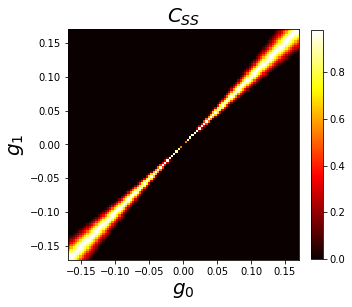

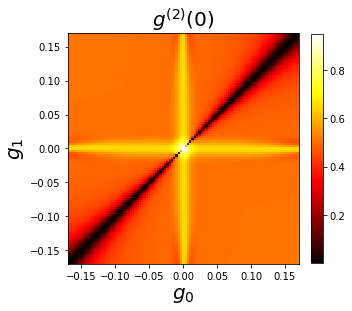

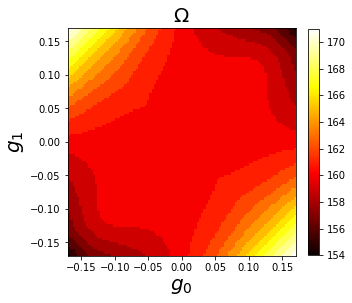

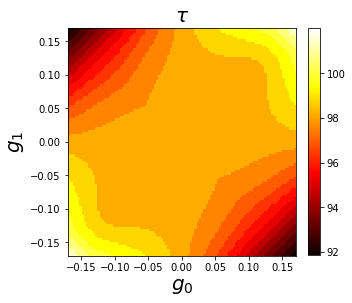

In [3]:
N = 2          # Number of spin 1/2's
M = 3          # Number of cavity modes

ws = [0.02, -0.02, 0.0]      # frequency/level spacing of each individual system
gs = [0.1, 0.1]              # position dependent couplings
ds = [0.1, 0.1, 0]           # driving strengths qb0,1, bosons 

# Lindblad collapse operators defined way above
cps = cops(kap, gam, gdph, n_th)

# detuning range
N_w = 101
w_r = 0.17
x_range = np.linspace(-w_r,w_r,N_w)
y_range = np.linspace(-w_r,w_r,N_w)

g0s = np.zeros((N_w,N_w))
cnc = np.zeros((N_w,N_w))

pwr_spc = [0] * N_w
g2s     = [0] * N_w

# discretized g2 time domain
steps = 1e3
tmax = 5e3
taus = np.linspace(0, tmax, steps)

# make 2D 'phase diagram'
for x_i in range(N_w):
    pwr_inr = [0] * N_w
    g2_yaxis= [0] * N_w
    for y_i in range(N_w):
        print(x_i,y_i)
        w0 = x_range[x_i]
        w1 = y_range[::-1][y_i]

        H = Ham(ws, [w0, w1], ds)                   # setup Hamiltonian 
        rho_ss = steadystate(H, cps)                # find steady state solution
        rdm = ptrace(rho_ss,[0,1])                  # reduced density matrix
        cnc[x_i, y_i] = concurrence(rdm)            # concurrence
        
        socf = g2(rho_ss, H, cps, taus)             # Second Order Correlation Function
        socf = socf/socf[-1]                        # normalize

        g2_yaxis[y_i] = socf                        # save g2
        g0s[x_i, y_i] = socf[0]                     # zero delay 
        pwr_inr[y_i] = np.abs(np.fft.fft(socf))     # power spectrum      

    g2s[x_i] = g2_yaxis     # all g2 correlation functions
    pwr_spc[x_i] = pwr_inr  # ALL power spectrums

    
frequencies = [[freq(pwr_spc[i][j],2) for i in range(N_w)] for j in range(N_w)] 
timescales =  [[tmax * np.pi / f for f in fs] for fs in frequencies] 

minx = min(x_range)
maxx = max(x_range)
miny = min(y_range)
maxy = max(y_range)

fs = str(20)

fig, ax = plt.subplots(1, figsize = (5,5))
im00 = ax.imshow(cnc, cmap  = 'hot', interpolation='nearest', extent=[minx, maxx, miny, maxy])
ax.set_title('$C_{SS}$', fontsize = fs)
ax.set_xlabel('$g_0$', fontsize = fs)
ax.set_ylabel('$g_1$', fontsize = fs)
fig.colorbar(im00, ax = ax, fraction = 0.045)
plt.tight_layout()
plt.savefig("coupling_concurrence.pdf")

fig, ax = plt.subplots(1, figsize = (5,5))
im00 = ax.imshow(g0s, cmap  = 'hot', interpolation='nearest', extent=[minx, maxx, miny, maxy])
ax.set_title('$g^{(2)}(0)$', fontsize = fs)
ax.set_xlabel('$g_0$', fontsize = fs)
ax.set_ylabel('$g_1$', fontsize = fs)
fig.colorbar(im00, ax = ax, fraction = 0.045)
plt.tight_layout()
plt.savefig("coupling_antibunching.pdf")

fig, ax = plt.subplots(1, figsize = (5,5))
im00 = ax.imshow(frequencies, cmap  = 'hot', interpolation='nearest', extent=[minx, maxx, miny, maxy])
ax.set_title('$\Omega$', fontsize = fs)
ax.set_xlabel('$g_0$', fontsize = fs)
ax.set_ylabel('$g_1$', fontsize = fs)
fig.colorbar(im00, ax = ax, fraction = 0.045)
plt.tight_layout()
plt.savefig("dcoupling_frequency.pdf")

fig, ax = plt.subplots(1, figsize = (5,5))
im00 = ax.imshow(timescales, cmap  = 'hot', interpolation='nearest', extent=[minx, maxx, miny, maxy])
ax.set_title('$\\tau$', fontsize = fs)
ax.set_xlabel('$g_0$', fontsize = fs)
ax.set_ylabel('$g_1$', fontsize = fs)
fig.colorbar(im00, ax = ax, fraction = 0.045)
plt.tight_layout()
plt.savefig("coupling_timescale.pdf")

### Drivings

Using the Heisenberg equation of motion we are able to solve for the time dynamics of the Pauli operators

look at specific region of interest at long timescales

In [103]:
N = 2          # Number of spin 1/2's
M = 3          # Number of cavity modes

ws = [0.005, -0.005, 0.0]      # frequency/level spacing of each individual system
gs = [0.1, 0.1]              # position dependent couplings
ds = [0.1, 0.1, 0]           # driving strengths qb0,1, bosons 

# Lindblad collapse operators defined way above
cps = cops(kap, gam, gdph, n_th)

# detuning range
N_x = 51
N_y = 51

minx = 1e-4
maxx = 0.05
miny = 1e-4
maxy = 0.05
x_range = np.linspace(minx,maxx,N_x)
y_range = np.linspace(miny,maxy,N_y)

g0s = np.zeros((N_x,N_y))
cnc = np.zeros((N_x,N_y))
coords = np.zeros((N_x,N_y))

pwr_spc = [0] * N_x
g2s     = [0] * N_x

steps = 1e3
tmax = 1e4
taus = np.linspace(0, tmax, steps)

# make 2D 'phase diagram'
for x_i in range(N_x):
    pwr_inr = [0] * N_y
    g2_yaxis= [0] * N_y
    print(x_i)
    for y_i in range(N_y):
#         print(x_i,y_i)
        
        w0 = x_range[x_i]
        w1 = y_range[y_i]
        coords[x_i,y_i] = w0 * w1

        H = Ham(ws, gs, [w0, w1, 0])                # setup Hamiltonian 
        rho_ss = steadystate(H, cps)                # find steady state solution
        rdm = ptrace(rho_ss,[0,1])                  # reduced density matrix
        cnc[x_i, y_i] = concurrence(rdm)            # concurrence
        
        socf = g2(rho_ss, H, cps, taus)             # Second Order Correlation Function
        socf = socf/socf[-1]                        # normalize

        g2_yaxis[y_i] = socf                        # save g2
        g0s[x_i, y_i] = socf[0]                     # zero delay 
        pwr_inr[y_i] = np.abs(np.fft.fft(socf))     # power spectrum      

    g2s[x_i] = g2_yaxis     # all g2 correlation functions
    pwr_spc[x_i] = pwr_inr  # ALL power spectrums

    
frequencies = [[freq(pwr_spc[i][j],2) for i in range(N_x)] for j in range(N_y)] 
timescales =  [[tmax * np.pi / f for f in fs] for fs in frequencies] 

minx = min(x_range)
maxx = max(x_range)
miny = min(y_range)
maxy = max(y_range)

fs = str(20)

fig, ax = plt.subplots(1, figsize = (5,5))
im00 = ax.imshow(cnc, origin='lower', cmap  = 'hot', interpolation='nearest', extent=[minx, maxx, miny, maxy])
ax.set_title('$C_{SS}$', fontsize = fs)
ax.set_xlabel('$\eta_0$', fontsize = fs)
ax.set_ylabel('$\eta_1$', fontsize = fs)
fig.colorbar(im00, ax = ax, fraction = 0.045)
plt.tight_layout()
# plt.savefig("driving_concurrence.pdf")

fig, ax = plt.subplots(1, figsize = (5,5))
im00 = ax.imshow(g0s, origin='lower', cmap  = 'hot', interpolation='nearest', extent=[minx, maxx, miny, maxy])
ax.set_title('$g^{(2)}(0)$', fontsize = fs)
ax.set_xlabel('$\eta_0$', fontsize = fs)
ax.set_ylabel('$\eta_1$', fontsize = fs)
fig.colorbar(im00, ax = ax, fraction = 0.045)
plt.tight_layout()
# plt.savefig("driving_antibunching.pdf")

fig, ax = plt.subplots(1, figsize = (5,5))
im00 = ax.imshow(frequencies, origin='lower', cmap  = 'hot', interpolation='nearest', extent=[minx, maxx, miny, maxy])
ax.set_title('$\Omega$', fontsize = fs)
ax.set_xlabel('$\eta_0$', fontsize = fs)
ax.set_ylabel('$\eta_1$', fontsize = fs)
fig.colorbar(im00, ax = ax, fraction = 0.045)
plt.tight_layout()
# plt.savefig("driving_frequency.pdf")

fig, ax = plt.subplots(1, figsize = (5,5))
im00 = ax.imshow(timescales, origin='lower', cmap  = 'hot', interpolation='nearest', extent=[minx, maxx, miny, maxy])
ax.set_title('$\\tau$', fontsize = fs)
ax.set_xlabel('$\eta_0$', fontsize = fs)
ax.set_ylabel('$\eta_1$', fontsize = fs)
fig.colorbar(im00, ax = ax, fraction = 0.045)
plt.tight_layout()
# plt.savefig("driving_timescale.pdf")

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:31: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


ValueError: attempt to get argmax of an empty sequence

In [126]:
frequencies = [[freq(pwr_spc[i][j],1) for i in range(N_x)] for j in range(N_y)] 
timescales =  [[tmax * np.pi / f for f in fs] for fs in frequencies] 

minx = min(x_range)
maxx = max(x_range)
miny = min(y_range)
maxy = max(y_range)

fs = str(20)

fig, ax = plt.subplots(1, figsize = (5,5))
im00 = ax.imshow(cnc, origin='lower', cmap  = 'hot', interpolation='nearest', extent=[minx, maxx, miny, maxy])
ax.set_title('$C_{SS}$', fontsize = fs)
ax.set_xlabel('$\eta_0$', fontsize = fs)
ax.set_ylabel('$\eta_1$', fontsize = fs)
fig.colorbar(im00, ax = ax, fraction = 0.045)
plt.tight_layout()
# plt.savefig("driving_concurrence.pdf")

fig, ax = plt.subplots(1, figsize = (5,5))
im00 = ax.imshow(g0s, origin='lower', cmap  = 'hot', interpolation='nearest', extent=[minx, maxx, miny, maxy])
ax.set_title('$g^{(2)}(0)$', fontsize = fs)
ax.set_xlabel('$\eta_0$', fontsize = fs)
ax.set_ylabel('$\eta_1$', fontsize = fs)
fig.colorbar(im00, ax = ax, fraction = 0.045)
plt.tight_layout()
# plt.savefig("driving_antibunching.pdf")

fig, ax = plt.subplots(1, figsize = (5,5))
im00 = ax.imshow(frequencies, origin='lower', cmap  = 'hot', interpolation='nearest', extent=[minx, maxx, miny, maxy])
ax.set_title('$\Omega$', fontsize = fs)
ax.set_xlabel('$\eta_0$', fontsize = fs)
ax.set_ylabel('$\eta_1$', fontsize = fs)
fig.colorbar(im00, ax = ax, fraction = 0.045)
plt.tight_layout()
# plt.savefig("driving_frequency.pdf")

fig, ax = plt.subplots(1, figsize = (5,5))
im00 = ax.imshow(timescales, origin='lower', cmap  = 'hot', interpolation='nearest', extent=[minx, maxx, miny, maxy])
ax.set_title('$\\tau$', fontsize = fs)
ax.set_xlabel('$\eta_0$', fontsize = fs)
ax.set_ylabel('$\eta_1$', fontsize = fs)
fig.colorbar(im00, ax = ax, fraction = 0.045)
plt.tight_layout()
# plt.savefig("driving_timescale.pdf")

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


ValueError: attempt to get argmax of an empty sequence

In [137]:
freq(pwr_spc[0][25],1)

1


71

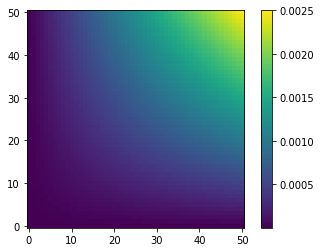

In [115]:
plt.imshow(coords.transpose(), origin='lower')
plt.colorbar()
ax.set_xlabel('$\eta_0$', fontsize = fs)
ax.set_ylabel('$\eta_1$', fontsize = fs)
plt.show()
coords;

## Plasmon Parameters

In [56]:
# Look at frequency for fig 4 Hou

N = 2          # Number of spin 1/2's
M = 3          # Number of cavity modes

# Lindblad collapse operators defined way above
cps = cops(kap, gam, gdph, n_th)

# detuning range
N_w = 201
w_r = 0.5
x_range = np.linspace(0,w_r,N_w)
y_range = np.linspace(0,w_r,N_w)

g2s = [[0] * N_w] * N_w
frq = np.zeros((N_w,N_w))
t0s = np.zeros((N_w,N_w))
g0s = np.zeros((N_w,N_w))
cnc = np.zeros((N_w,N_w))


# discretized g2 time domain
steps = 2e3
tmax = 1e3
taus = np.linspace(0, tmax, steps)

# make 2D 'phase diagram'
for x_i in range(N_w):
    for y_i in range(N_w):
        w0 = x_range[x_i]
        w1 = y_range[::-1][y_i]

        H = Ham([1e-3, -1e-3, 0.0], [w0, w0], [0, 0, w1])  # setup Hamiltonian 
        rho_ss = steadystate(H, cps)                # find steady state solution
        rdm = ptrace(rho_ss,[0,1])                  # reduced density matrix
        socf = g2(rho_ss, H, cps, taus)             # Second Order Correlation Function
        socf = socf/socf[-1]                        # normalize

        cnc[x_i, y_i] = concurrence(rdm)             # concurrence
        g2s[x_i][y_i] = socf                         # save g2
        g0s[x_i, y_i] = socf[0]                      # zero delay 
        ps = np.abs(np.fft.fft(socf))                # power spectrum

        
        frequencies = ss.argrelmax(ps, order = 3)[0] # candidate frequencies
        if len(frequencies) == 0:
            f = float(tmax)
            print("no oscillations :(")
        else:
            f = float(frequencies[0])                  

        frq[x_i, y_i] = f        
        t0s[x_i, y_i] = tmax * np.pi / f             # timescale         

minx = min(x_range)
maxx = max(x_range)
miny = min(y_range)
maxy = max(y_range)        

fig, ax = plt.subplots(2, 2, figsize = (15,15))

im00 = ax[0,0].imshow(cnc, cmap  = 'hot', interpolation='nearest', extent=[minx, maxx, miny, maxy])
ax[0,0].set_title('Concurrence')
ax[0,0].set_xlabel('$g/\Gamma$')
ax[0,0].set_ylabel('$\eta/\Gamma$')
fig.colorbar(im00, ax=ax[0,0], fraction = 0.22)

im01 = ax[0,1].imshow(g0s, cmap  = 'hot', interpolation='nearest', extent=[minx, maxx, miny, maxy])
ax[0,1].set_title('$g^{(2)}(0)$')
ax[0,1].set_xlabel('$g/\Gamma$')
ax[0,1].set_ylabel('$\eta/\Gamma$')
fig.colorbar(im01, ax=ax[0,1], fraction = 0.22)

im10 = ax[1,0].imshow(frq, cmap='hot', interpolation='nearest', extent=[minx, maxx, miny, maxy])
ax[1,0].set_title('$f_A$')
ax[1,0].set_xlabel('$g/\Gamma$')
ax[1,0].set_ylabel('$\eta/\Gamma$')
fig.colorbar(im10, ax=ax[1,0], fraction = 0.22)

im11 = ax[1,1].imshow(t0s, cmap='hot', interpolation='nearest', extent=[minx, maxx, miny, maxy])
ax[1,1].set_title('$\\tau_A$')
ax[1,1].set_xlabel('$g/\Gamma$')
ax[1,1].set_ylabel('$\eta/\Gamma$')
fig.colorbar(im11, ax=ax[1,1], fraction = 0.22)

plt.tight_layout()
plt.show()

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:25: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:90: RuntimeWarning: invalid value encountered in true_divide
/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:68: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, plus)
/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:69: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, minus)


no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillations :(
no oscillati

KeyboardInterrupt: 

###### Theoretical Frequencies -- in weak coupling limit using adiabatic elimination of fields

In [25]:
# Replicate Hou Fig 5 

N = 2          # Number of spin 1/2's
M = 3          # Number of cavity modes

ws = [1e-3, -1e-3, 0]       # frequency/level spacing of each individual system
gs = [0.2, 0.2]              # position dependent couplings
ds = [0.0, 0.0, 0.1]           # driving strengths qb0,1, bosons 

# Lindblad collapse operators defined way above
cps = cops(kap, gam, gdph, n_th)

# detuning range
N_w = 31
w_r = 0.05
x_range = np.linspace(-w_r,w_r,N_w)
y_range = np.linspace(-w_r,w_r,N_w)

g0s = np.zeros((N_w,N_w))
cnc = np.zeros((N_w,N_w))

pwr_spc = [0] * N_w
g2s     = [0] * N_w

# discretized g2 time domain
steps = 1e3
tmax = 5e4
taus = np.linspace(0, tmax, steps)

# make 2D 'phase diagram'
for x_i in range(N_w):
    pwr_inr = [0] * N_w
    g2_yaxis= [0] * N_w
    for y_i in range(N_w):
#         print(x_i,y_i)
        w0 = x_range[x_i]
        w1 = y_range[::-1][y_i]

        H = Ham([w0, w1, 0], gs, ds)                # setup Hamiltonian
        rho_ss = steadystate(H, cps)                # find steady state solution
        rdm = ptrace(rho_ss,[0,1])                  # reduced density matrix
        cnc[x_i, y_i] = concurrence(rdm)            # concurrence
        
        socf = g2(rho_ss, H, cps, taus)             # Second Order Correlation Function
        socf = socf/socf[-1]                        # normalize

        g2_yaxis[y_i] = socf                        # save g2
        g0s[x_i, y_i] = socf[0]                     # zero delay 
        pwr_inr[y_i] = np.abs(np.fft.fft(socf))     # power spectrum      

    g2s[x_i] = g2_yaxis     # all g2 correlation functions
    pwr_spc[x_i] = pwr_inr  # ALL power spectrums

    
frequencies = [[freq(pwr_spc[i][j],2) for i in range(N_w)] for j in range(N_w)] 
timescales =  [[tmax * np.pi / f for f in fs] for fs in frequencies] 

minx = min(x_range)
maxx = max(x_range)
miny = min(y_range)
maxy = max(y_range)

fs = str(20)


fig, ax = plt.subplots(1, figsize = (5,5))
im00 = ax.imshow(cnc, cmap  = 'hot', interpolation='nearest', extent=[minx, maxx, miny, maxy])
ax.set_title('$C_{SS}$', fontsize = fs)
ax.set_xlabel('$\Delta_0$', fontsize = fs)
ax.set_ylabel('$\Delta_1$', fontsize = fs)
fig.colorbar(im00, ax = ax, fraction = 0.045)
plt.tight_layout()

fig, ax = plt.subplots(1, figsize = (5,5))
im00 = ax.imshow(g0s, cmap  = 'hot', interpolation='nearest', extent=[minx, maxx, miny, maxy])
ax.set_title('$g^{(2)}(0)$', fontsize = fs)
ax.set_xlabel('$\Delta_0$', fontsize = fs)
ax.set_ylabel('$\Delta_1$', fontsize = fs)
fig.colorbar(im00, ax = ax, fraction = 0.045)
plt.tight_layout()


fig, ax = plt.subplots(1, figsize = (5,5))
im00 = ax.imshow(frequencies, cmap  = 'hot', interpolation='nearest', extent=[minx, maxx, miny, maxy])
ax.set_title('$\Omega$', fontsize = fs)
ax.set_xlabel('$\Delta_0$', fontsize = fs)
ax.set_ylabel('$\Delta_1$', fontsize = fs)
fig.colorbar(im00, ax = ax, fraction = 0.045)
plt.tight_layout()

fig, ax = plt.subplots(1, figsize = (5,5))
im00 = ax.imshow(timescales, cmap  = 'hot', interpolation='nearest', extent=[minx, maxx, miny, maxy])
ax.set_title('$\\tau$', fontsize = fs)
ax.set_xlabel('$\Delta_0$', fontsize = fs)
ax.set_ylabel('$\Delta_1$', fontsize = fs)
fig.colorbar(im00, ax = ax, fraction = 0.045)
plt.tight_layout()


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:28: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/integrate/_ode.py:869: UserWarning: zvode: Excess work done on this call. (Perhaps wrong MF.)
  'Unexpected istate=%s' % istate))


Exception: ODE integration error: Try to increase the allowed number of substeps by increasing the nsteps parameter in the Options class.

###### OSCILLATION TROUBLESHOOTING

0.12 0.12
0.980368050042 8.44352092394e-06 31.25


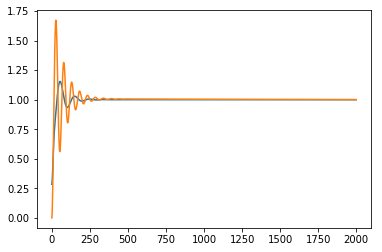

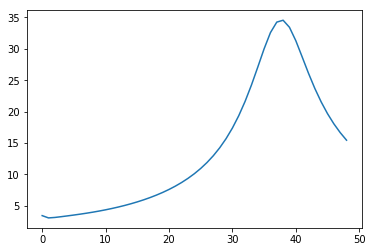

39

In [292]:
num = 35
ix, iy = num, N_w - num - 1

print(x_range[ix], y_range[::-1][iy])
print(cnc[ix, iy], g0s[ix, iy], t0s[ix, iy])

# setup Hamiltonian 
H = Ham(ws, gs, [x_range[ix], y_range[::-1][iy], 0])                
rho_ss = steadystate(H, cps)                # find steady state solution
rdm = ptrace(rho_ss,[0,1])                  # reduced density matrix
socf = g2(rho_ss, H, cps, taus)             # Second Order Correlation Function
socf = socf/socf[-1]                        # normalize
        
        
prob = g2s[ix][iy]
ps = np.abs(np.fft.fft(socf))


plt.plot(prob)
plt.plot(socf)
plt.show()
plt.plot(ps[1:50])
plt.show()

np.argmax(ps[1:int(steps/2)]) + 1